# Introduction

This pipeline takes a list of text bodies and then applies topic modelling and sentiment analysis to each entry. The final output of this process is a report on any significant correlations between topics and sentiments.
This is intended as an extensible prototype. This pipeline can be configured to work with any list of text bodies, but is here used to assess if news articles are treating topics particularly positively or negatively. In future, this prototype could be developed for applications such as assessing bias in different media outlets, or estimating the impact of media sentiment on public opinion. 


# Literature *Review*

NLP techniques have often been used in automated public opinion analysis. As opposed to analyzing a population’s thoughts about a topic through surveys or interviews, NLP can be used to determine the public’s thoughts and feelings about a topic based on what they are saying and writing. The age of social media provides researchers with massive amounts of text content to analyze for public opinion. There is much research using topic modelling and sentiment analysis together to assess what topics the corpus is discussing and how positively or negatively that topic is being discussed. 
Automated public opinion analysis has been developed since the 2010s. LDA and sentiment analysis with the VADER system has in particular, risen in popularity among researchers. Using these two NLP techniques together can yield a ‘sentiment per topic’ distribution. Certain researchers have discovered interesting correlations with actual public and economic events and certain sentiments-on-topics. 
The role of the media in public opinion formation is also an important research topic. The same techniques that analyze sentiment per topic in public discourse can also be applied to news media. This project aims to apply these NLP techniques for topic modeling and sentiment analysis to yield the sentiment per topic of news media articles. This could be used to research the impact of media discourse on public opinion by coming public sentiment-per-topic with media sentiment-per-topic over time. 


## Demonstration
What follows is a deomonstration of the pipeline execution.

# Configuration

In the following section, we:      
* Import required modules
* Set the configratuin constants, inluding the tokenizer functions, stop words, etc. 
* Define the functons for use in the 'Execution' section.
* Connect this runtime to filestorage (Google Drive) to store the output file. 

## Modules

In [ ]:
import pandas as pd
import seaborn as sb
import nltk
from scipy import stats
from scipy.stats import pearsonr
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
import time
import random
import os
import re
import numpy as np
from gensim import corpora
from gensim.models import CoherenceModel 
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
nltk.download('stopwords')
nltk.download('wordnet')


!pip install pyLDAvis
import pyLDAvis
from pyLDAvis import gensim_models


import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Constants

The constants to be set for this pipeline are:

* INPUT_FILE = The location of the input file, which can be the same as the output file of the preceeding, web scraper pipeline. 
* TEXT_COLUMN =The column header of the column which is the text bodies. 
* STOP_WORDS = A selected NLTK stopwords object
* EXTENDED_STOP_WORDS = A list of extra stop words to include. 
EXCLUDE_CHARACTERS = A set of characters to exclude, such as punctuation. 
* TOKENIZER_FUNCTION = The tokenizer function. 
* PASSES= The number of passes conducted by the LDA
* GRAM_N = Set 2 for bigrams, 3 for trigrams, etc. 
* DELIMITER = Typically white space, this is used to concatenate tokens into the normalized text blobs. 
* NUM_TOPICS = A list of integers, this is the number of topics the LDA will try and select the most coherent one. 
* ALPHA = The significance threshold for testing if there are significant relationships between sentiments and topics. 
* SEED = Random seed. 

In [ ]:
INPUT_FILE = '/content/drive/MyDrive/MA5851_A3/scrape_results.csv'
TEXT_COLUMN ="Bag Of Words"
STOP_WORDS = stopwords.words('english')
EXTENDED_STOP_WORDS = ['m','u','also','est','span','a','n','said','time','one'] 
EXCLUDE_CHARACTERS = set(string.punctuation)
TOKENIZER_FUNCTION = WordNetLemmatizer().lemmatize
NUM_TOPICS=12
PASSES=50
#Set bigram, trigram, etc
GRAM_N = 2
DELIMITER = b' '
NUM_TOPICS = [3,5,7]
ALPHA = 0.1
SEED = 42

## File Storage

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Functions

In [ ]:
def Clean(doc, tokenizer, exclude, stop):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(tokenizer(word) for word in punc_free.split())
    return normalized

In [ ]:
def Sent_To_Words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))

In [ ]:
def Make_Ngrams(texts, gram_mod):
    return [gram_mod[doc] for doc in texts]

In [ ]:
def Get_Tuple_Value(tup: tuple, x: int):
  return tup[x]

In [ ]:
def Filter_By_P_Value(coef, p_values, alpha):
      output = coef.copy(deep =True)
      for column in p_values:
        for i, j in p_values[column].items():
            if j > alpha:
              output.loc[i, column] = float("NaN")
      return output

def Add_P_Value_Markers(coef, p_values, alpha, character):
      output = coef.copy(deep =True)
      for column in p_values:
        for i, j in p_values[column].items():
            if j < alpha:
              output.loc[i, column] = str(coef.loc[i, column].round(decimals = 6)) + character
            else:
                output.loc[i, column] = coef.loc[i, column]
      return output

def Pearsonr_Pval(x,y):
        return stats.pearsonr(x,y)[1]

def Set_All_Seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    np.random.RandomState(seed)

In [ ]:
def Plot_Word_Count(n: int,text_bodies: List):
  count_vectorizer = CountVectorizer(max_features=n, STOP_WORDS,tokenizer=TOKENIZER_FUNCTION)
  Y = count_vectorizer.fit_transform(text_bodies)
  word_counts = Y.toarray().sum(axis=0)
  key_words = count_vectorizer.get_feature_names()
  df = pd.DataFrame({"Token":key_words,"Frequency":word_counts})
  df = df.sort_values(by='Frequency', ascending=False)
  df.iloc[0:20,:].plot.bar(x='Token', y='Frequency', rot=90)

# Execute

## Data Preprocessing

### Sentiment Analysis
The raw data inputted into this pipeline features:
*	The URL of the news article
*	The blob of text extracted the article
*	The title of the article

The previous pipeline has already tested that no articles appear to be missing substantial body text, which could be caused, for example, from the web crawler failing t extract meaningful text. 

Now we clean this text and convert it to vector space by:

*	Clean the text of unwanted characters (ie: ‘>’, ‘\’)
*	Converting all test to lowercase. 
*	Tokenize with the WordNet lemmatizer. See hyperparameter selection section for details. 
*	Removing stop words from the NLTK English stop word list, plus custom stop words identified by exploring the residual html text in the corpus. 
*	Applying the genism simple text cleaning, which removes punctuation, accents.

This list of normalized text blobs is sufficient input for the VADER sentiment analysis function. This system can then output the sentiment metrics for each text blob. 

###Topic Modelling
The LDA topic detection model requires some features in addition to the text normalization committed so far. To prepare the data for topic modelling we:

*	Apply nGram modification – in this case we select bigrams. See hyperparameter section for details. 

Now we can derive the document-term matrix for each bigram and document and input this to an LDA model for topic analysis. Sentiment analysis can be applied to the list of normalized text blobs. 


In [ ]:
Set_All_Seeds(SEED)
start_time = time.time()

In [ ]:
data = pd.read_csv(INPUT_FILE)
len(data)

144

In [ ]:
Plot_Word_Count(30, data[TEXT_COLUMN])

In [ ]:
%%capture
#Select list of documents from data 
STOP_WORDS.extend(EXTENDED_STOP_WORDS)
# String cleaning
doc_clean = [Clean(doc, tokenizer=TOKENIZER_FUNCTION,exclude=EXCLUDE_CHARACTERS,stop=set(STOP_WORDS)).split() for doc in data[TEXT_COLUMN]]

#Make Ngrams
words = Sent_To_Words(doc_clean)
gram_mod = gensim.models.Phrases(words, min_count=GRAM_N, delimiter=DELIMITER)
ngrams = Make_Ngrams(doc_clean, gram_mod)

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(ngrams)

# Converting list of documents into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in ngrams]

# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

corpus = [dictionary.doc2bow(text) for text in ngrams]


## Sentiment Analysis

VADER is a dictionary based approach to estimating overall text sentiment and outputs the estimated positivity, neutrality and negative content of the text sentiment. VADER has been a popular sentiment analysis method for researchers since the 2010s. 

### Hyperparameters
Because this is a prototype, there is minimal hyperparameter tuning.
The hyperparameters that have been selected are:
*	The default VADER dictionary is applied. 
*	The WordNet lemmatizer is used to tokenize the text. This choice of tokenizer was arbitrary for the prototype. Future iterations could involve tokenizer selection by grid searching. 


In [ ]:
vader = SentimentIntensityAnalyzer()
sentiment_scores = []
for doc in doc_complete:
  sentiment_scores.append(vader.polarity_scores(doc))

In [ ]:
sentiments = pd.DataFrame(sentiment_scores)

Text(0.5, 1.0, 'Distribution of Sentiment across Articles')

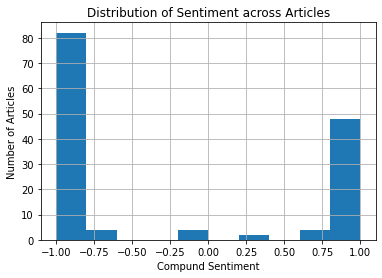

In [ ]:
ax = sentiments['compound'].hist()
ax.set_xlabel("Compund Sentiment")
ax.set_ylabel("Number of Articles")
ax.set_title("Distribution of Sentiment across Articles")

## Topic Modelling

LDA is a popular algorithm for topic modelling. It was selected because it is used in preceding research into public opinion analysis and this experiment is aimed at recreating this topic modelling with media as the target corpus.

### Hyperparameters
The LDA will use the same normalized corpus as the sentiment analyzer. There are two additional hyperparameters for the LDA:

*	N value for nGram modification: We converted the tokenized text into bigram terms. This was an arbitrary selection for the prototype which can be tuned with grid search in future iterations. 

*	The K value for number of topics to be modelled. This hyperparameter was found through grid search of this one variable. The user sets a range of k values to test. The pipeline tries each one and selects the k value with the highest overall coherence. Figure 1 and 2 indicate the results of automatically tuning this hyperparameter. 


In [ ]:
%%capture
max_coherence = 0
optimal_n_topics = 0
perplexity_scores = []
coherence_scores = []
for n in NUM_TOPICS:
  ldamodel = Lda(doc_term_matrix, num_topics=n, id2word = dictionary, passes=PASSES, minimum_probability=MINIMUM_PROBABILITY)
  perplexity = ldamodel.log_perplexity(corpus)
  coherence = CoherenceModel(model=ldamodel, texts=ngrams, dictionary=dictionary, coherence='c_v').get_coherence()
  perplexity_scores.append(perplexity)
  coherence_scores.append(coherence)
  if coherence > max_coherence:
    max_coherences = coherence
    optimal_n_topics = n
ldamodel = Lda(doc_term_matrix, num_topics=optimal_n_topics, id2word = dictionary, passes=PASSES, minimum_probability=MINIMUM_PROBABILITY)

Text(0.5, 1.0, 'Coherence')

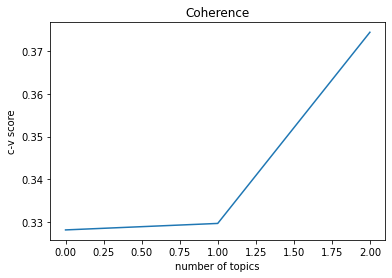

In [ ]:
plt.plot(coherence_scores)
plt.xlabel('number of topics')
plt.ylabel('c-v score')
plt.title('Figure 1: Coherence')

Text(0.5, 1.0, 'Coherence')

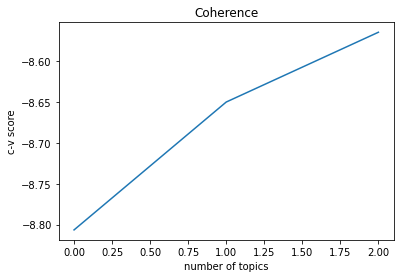

In [ ]:
plt.plot(perplexity_scores)
plt.xlabel('number of topics')
plt.ylabel('c-v score')
plt.title('Figure 2: Perplexity')

### Figure 3: Topic Modeling Results

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.205437 -0.168086       1        1  41.479724
5      0.122560 -0.010041       2        1  16.492852
2      0.111918  0.006975       3        1  14.361864
3     -0.155223  0.224664       4        1  11.442516
6      0.076210 -0.002907       5        1   7.470534
0      0.080995 -0.004969       6        1   5.885661
4     -0.031024 -0.045636       7        1   2.866850, topic_info=              Term        Freq       Total Category  logprob  loglift
757        covid19  513.000000  513.000000  Default  30.0000  30.0000
3526       vaccine  156.000000  156.000000  Default  29.0000  29.0000
337         police  798.000000  798.000000  Default  28.0000  28.0000
18948  rittenhouse  152.000000  152.000000  Default  27.0000  27.0000
12055       arbery  179.000000  179.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
756          covid   11.012997  250.424773   Topic7  -6.0572   0.4279
463            two   10.373112  403.606300   Topic7  -6.1171  -0.1093
15              50    9.413348   88.618131   Topic7  -6.2142   1.3097
1572         would    9.297231  395.325901   Topic7  -6.2266  -0.1980
98      classclass    9.169817  103.500271   Topic7  -6.2404   1.1283

[474 rows x 6 columns], token_table=      Topic      Freq Term
term                      
8114      4  0.936783  175
4         1  0.310950   18
4         2  0.131918   18
4         3  0.037691   18
4         4  0.131918   18
...     ...       ...  ...
1585      5  0.151160    –
1585      6  0.028598    –
3669      1  0.731983    —
3669      2  0.010925    —
3669      5  0.251278    —

[967 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 3, 4, 7, 1, 5])

Here, we give each topic a name based on the top three most salent words.

In [ ]:
topics = pd.DataFrame(ldamodel[corpus])
topics = topics.applymap(lambda x: Get_Tuple_Value(x,1))

In [ ]:
column_names_raw = pd.DataFrame(ldamodel.print_topics(num_topics = optimal_n_topics, num_words = 5))[1]
column_names = []
for name in column_names_raw:
  name = str(re.findall('"([^"]*)"',name))
  column_names.append(name)
topics.columns = column_names

## Regression Analysis

The results from the sentiment analysis and the topic modelling are appended as new columns to the original data set, which gives us the following new schema:

Each topic (there will be k number of topics, and therefore columns.
*	This is a float which indicates the estimation that this article is about this topic. The larger the value, the more this article appears to involve a discussion of this topic. 
*	For readability, topics are named by taking the top 3 most salient words in the topic and appending them into a list. This is to give the reader some insight into what the topic regards. 

Four sentiment variables: 
*	Neutrality: The normalized sum amount of terms which is neither positive or negative
*	Positivity: Positive terms (according to the VADER dictionary)
*	negative Negative terms
*	Compound: The normalized mean of positive minus negative sentiment. 

From this data, we can output the final deliverable from this pipeline: We want to know if any topics have a significant correlation with any of the sentiment metrics. We se pairwise Pearson correlation to determine if an article that is more about a given topic, has a significant correlation with a sentiment. 

Figure 4 shows this output. Note than variable pairs where the correlation is not significant (p< 0.1) are blank. 


In [ ]:
regression_analysis_data = pd.concat([topics,sentiments], axis = 1)
len(regression_analysis_data)

144

Text(0.5, 1.0, 'Correlation Coefficients - Topics and Sentiments')

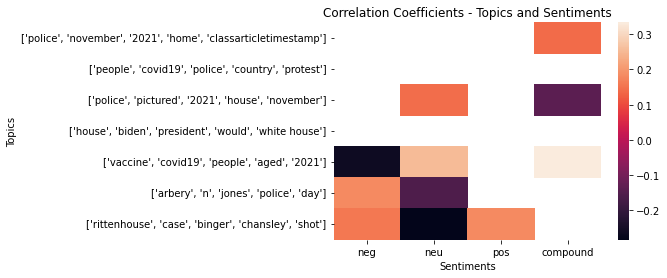

In [ ]:
sentiment_variables = ["neg","neu","pos","compound"]
corr = regression_analysis_data.corr()
p_values = regression_analysis_data.corr(method = Pearsonr_Pval)
vis_data = Filter_By_P_Value(corr,p_values,ALPHA)
ax = plt.axes()
sb.heatmap(vis_data.loc[:,sentiment_variables].drop(sentiment_variables, axis = 0), ax=ax)
ax.set_xlabel("Sentiments")
ax.set_ylabel("Topics")
ax.set_title('Correlation Coefficients - Topics and Sentiments')

In [ ]:
execution_time = time.time() - start_time
execution_time

213.5309453010559

# Discussion